# Derivation

Discretely many importance weights and rewards, control variates $\vec{\tau}$, maximum likelihood of sample $\{ (w_n, r_n, \vec{\tau}_n) \}_{n=1}^N$ from $h$ is 
\begin{alignat}{2}
&\!\max_{Q \succeq 0} &\qquad& \sum_n \log(Q_{w_n, r_n, \vec{\tau}_n}),\label{eq:mle} \\
&\text{subject to} &  & \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} = 1, \tag{$\beta$} \label{eq:mlesumw} \\
&                  &  & \sum_{w,r,\vec{\tau}} w Q_{w,r,\vec{\tau}} = 1, \tag{$\gamma$} \label{eq:mlesum} \\
&                  &  & \sum_{w,r,\vec{\tau}} \vec{\tau} Q_{w,r,\vec{\tau}} = 0, \tag{$\vec{\delta}$} \label{eq:mlesumdr}
\end{alignat}
Estimate is $\hat V(\pi) = \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} w r$.

Dual (ignoring constants) is $$
\ldots
$$

# Tests

## Comparison with CVX

In [1]:
# CVXPY (primal) implementation

class MLETest:
    @staticmethod
    def bitgen(minv, maxv):
        def bitgenhelp(vals, minv, maxv, pos, length):
            if pos >= length:
                yield tuple(vals)
            else:
                vals[pos] = minv[pos]
                yield from bitgenhelp(vals, minv, maxv, pos+1, length)
                vals[pos] = maxv[pos]
                yield from bitgenhelp(vals, minv, maxv, pos+1, length)
            
        assert len(minv) == len(maxv)
        length = len(minv)
        yield from bitgenhelp([None]*length, minv, maxv, 0, length) 

    @staticmethod
    def cvxdualestimate(data, wmin, wmax, cvmin, cvmax, rmin=0, rmax=1):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            assert np.all(cvsi >= cvmin)
            assert np.all(cvsi <= cvmax)
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
            ncvs = len(cvsi)
        assert n >= 1
        cdict.default_factory = None
        
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])

        gamma = cp.Variable()
        delta = cp.Variable(ncvs)
        
#         from pprint import pformat
#         print(pformat({
#             'cdict': cdict,
#             'C': C,
#             'wvec': wvec,
#             'cvsmat': cvsmat,
#             'gamma': gamma,
#             'delta': delta,
#         }))        
        
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(1 + gamma * (wvec - 1) + cp.matmul(cvsmat, delta))))), [
           1 + gamma * (w - 1) + cp.matmul(np.array(bitvec), delta) >= 0
           for w in (wmin, wmax)
           for bitvec in MLETest.bitgen(cvmin, cvmax)
        ])
        prob.solve(solver='ECOS')
        
        Q = np.array([ c / (n * (1 + gamma.value * (w - 1) + delta.value.dot(np.array(cvs))))
                       for (w, r, cvs), c in cdict.items() ])
        rawsumofw = wvec.dot(Q)
        rawsumofone = np.sum(Q)
        rawsumofcvs = np.matmul(cvsmat.T, Q)
        
        vhat = 0
        for (w, r, cvs), c in cdict.items():
            q = c / (n * (1 + gamma.value * (w - 1) + delta.value.dot(np.array(cvs))))
            vhat += q * w * r
           
        # NB: no explicit primal reconstruction necessary (!)
        vmin = vhat + max(0.0, 1 - rawsumofw) * rmin
        vmax = vhat + max(0.0, 1 - rawsumofw) * rmax
        vhat += max(0.0, 1 - rawsumofw) * (rmax - rmin) / 2
        
        from scipy.special import xlogy

        return vhat, {
            'vmin': vmin,
            'vmax': vmax,
            'gamma': n * gamma.value,
            'delta': n * delta.value,
            'qstar': { (w, r, cvs): c / (n * (1 + gamma.value * (w - 1) + delta.value.dot(np.array(cvs))))
                       for (w, r, cvs), c in cdict.items() if c > 0  },
            'likelihood': np.sum(xlogy(C, Q)),
            'rawsumofone': rawsumofone,
            'rawsumofw': rawsumofw,
            'rawsumofcvs': rawsumofcvs,
        }
        
    @staticmethod
    def cvxestimate(data, wmin, wmax, cvmin, cvmax, rmin=0, rmax=1):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            assert np.all(cvsi >= cvmin)
            assert np.all(cvsi <= cvmax)
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
        assert n >= 1
        for bitvec in MLETest.bitgen(cvmin, cvmax):
            cdict[(wmin, rmin, bitvec)] += 0
            cdict[(wmin, rmax, bitvec)] += 0
            cdict[(wmax, rmin, bitvec)] += 0
            cdict[(wmax, rmax, bitvec)] += 0
        cdict.default_factory = None
                       
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])
        Q = cp.Variable(len(C))
                       
#         from pprint import pformat
#         print(pformat({
#             'cdict': cdict,
#             'C': C,
#             'wvec': wvec,
#             'cvsmat': cvsmat,
#             'Q': Q
#         }))
                       
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(Q)))), [
            cp.sum(cp.multiply(wvec / wmax, Q)) == 1 / wmax,
            cp.sum(Q) == 1,
            cp.matmul(cvsmat.T, Q) == 0
        ])
        prob.solve(solver='ECOS')
        vmax, vmin = 0, 0
        for ((w, r, _), c), q in zip(cdict.items(), Q.value):
            if c > 0:
                vmax += q * w * r
                vmin += q * w * r
            else:
                vmax += q * w * rmax
                vmin += q * w * rmin
                                          
        vhat = (vmin + vmax) / 2              
 
        from scipy.special import xlogy
    
        return vhat, { 
            'vmax': vmax,
            'vmin': vmin,
            'qstar': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c > 0 },
#             'qex': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c == 0 and q > 0},
            'likelihood': np.sum(xlogy(C, Q.value)),
            'sumofone': np.sum(Q.value),
            'sumofw': wvec.dot(Q.value),
            'sumofcvs': np.matmul(cvsmat.T, Q.value)
        }
    
def flass():
    from importlib import reload
    import numpy as np
    import MLE.MLE
    import environments.DoubleDouble
    reload(MLE.MLE)
    
    numactions = 5
    ddm = environments.DoubleDouble.DoubleDouble(numactions=numactions, seed=48, wsupport=[0, 2, 1000], expwsq=100)
    wmin, wmax, cvmin, cvmax = ddm.range()
    (truevalue, data) = ddm.samplewithcvs(12000)
    return (truevalue, data, 
            MLETest.cvxestimate(data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
            MLETest.cvxdualestimate(data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
            MLE.MLE.estimate(lambda: ((c, w, r) for c, w, r, _ in data), wmin=wmin, wmax=wmax),
            MLE.MLE.estimatewithcv(lambda: data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
           ) 

def turg():
    from pprint import pformat
    from numpy import array
    import MLE.MLE
    
    for data in [
        {'cvmax': array([999., 999., 999., 999.]),
         'cvmin': array([-1., -1., -1., -1.]),
         'data': [(3, 0, 0, array([ 0,  0,  0, -1])),
                  (1, 0, 0, array([ 0,  0, -1,  0])),
                  (1, 2, 0, array([1, 0, 0, 0])),
                  (1, 2, 0, array([0, 0, 0, 1])),
                  (1, 2, 0, array([0, 1, 0, 0])),
                  (1, 2, 0, array([0, 0, 0, 0])),
                  (1, 2, 1, array([0, 0, 0, 1])),
                  (1, 2, 1, array([0, 1, 0, 0]))],
         'i': 81,
         'truevalue': 0.1373093166658105,
         'wmax': 1000,
         'wmin': 0}
    ]:
        print(pformat(
            MLETest.cvxestimate(data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                    cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)
        print(pformat(
            MLETest.cvxdualestimate(data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                    cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)
        print(pformat(
            MLE.MLE.estimatewithcv(datagen=lambda: data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                   cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)

turg()
flass()

(0.3223340274991616,
 {'likelihood': -2.107394972998062,
  'qstar': {(0, 0, (0, 0, -1, 0)): 0.10307455921633439,
            (0, 0, (0, 0, 0, -1)): 0.30911170383173925,
            (2, 0, (0, 0, 0, 0)): 0.09712363042448455,
            (2, 0, (0, 0, 0, 1)): 0.09712352181260896,
            (2, 0, (0, 1, 0, 0)): 0.056117464477820615,
            (2, 0, (1, 0, 0, 0)): 0.0801737605588304,
            (2, 1, (0, 0, 0, 1)): 0.09712352181260896,
            (2, 1, (0, 1, 0, 0)): 0.056117464477820615},
  'sumofcvs': array([-5.42875356e-07,  8.14408657e-07, -1.68551861e-09, -1.21621993e-09]),
  'sumofone': 0.9999999998494402,
  'sumofw': 0.9992628369649531,
  'vmax': 0.3381860824174641,
  'vmin': 0.30648197258085913})
(0.30003202513097904,
 {'delta': array([1.80158273e-03, 9.99749722e+00, 1.18268375e-07, 1.18210028e-07]),
  'gamma': 0.0007008027544258915,
  'likelihood': -2.1116308304987186,
  'qstar': {(0, 0, (0, 0, -1, 0)): 0.10000700970155273,
            (0, 0, (0, 0, 0, -1)): 0.3000210291

(0.019239877299983728,
 [(1370, 0, 0, array([ 0, -1,  0,  0])),
  (1278, 0, 0, array([0, 0, 0, 0])),
  (1332, 0, 0, array([ 0,  0,  0, -1])),
  (1319, 0, 0, array([-1,  0,  0,  0])),
  (1335, 0, 0, array([ 0,  0, -1,  0])),
  (1087, 2, 0, array([1, 0, 0, 0])),
  (997, 2, 0, array([0, 0, 0, 1])),
  (1080, 2, 0, array([0, 0, 0, 0])),
  (1082, 2, 0, array([0, 1, 0, 0])),
  (1091, 2, 0, array([0, 0, 1, 0])),
  (5, 2, 1, array([0, 1, 0, 0])),
  (5, 2, 1, array([1, 0, 0, 0])),
  (8, 2, 1, array([0, 0, 0, 1])),
  (7, 2, 1, array([0, 0, 0, 0])),
  (3, 2, 1, array([0, 0, 1, 0])),
  (1, 1000, 0, array([0, 0, 0, 0]))],
 (0.015818386567853466,
  {'vmax': 0.026968758285257282,
   'vmin': 0.004668014850449648,
   'qstar': {(0, 0, (0, -1, 0, 0)): 0.11416608447622423,
    (0, 0, (0, 0, 0, 0)): 0.10649975487004196,
    (0, 0, (0, 0, 0, -1)): 0.11088946274448659,
    (0, 0, (-1, 0, 0, 0)): 0.10991636654178477,
    (0, 0, (0, 0, -1, 0)): 0.11124966927015993,
    (2, 0, (1, 0, 0, 0)): 0.09058360555202394,

In [2]:
def testestimate():
    from importlib import reload
    from math import ceil
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys
    import environments.DoubleDouble

    reload(MLE.MLE)

    wsupport = [ 0, 2, 10 ]
    wmax = wsupport[-1]
    env = environments.DoubleDouble.DoubleDouble(numactions=2, seed=45, wsupport=wsupport, expwsq=5)
    
    for ndata in tqdm(map(ceil, np.logspace(1, 6, 14)), file=sys.stderr, total=14):
        for i in range(101):
            (truevalue, data) = env.samplewithcvs(ndata)
            vhat, qstar = MLE.MLE.estimatewithcv(lambda: data, wmin=0, wmax=wmax, 
                                                 cvmin=-1*np.ones(2), cvmax=(wmax-1)*np.ones(2),
                                                 raiseonerr=True)
            try:
                cvxvhat, cvxqstar = MLETest.cvxdualestimate(data, wmin=0, wmax=wmax, 
                                                            cvmin=-1*np.ones(2), cvmax=(wmax-1)*np.ones(2))
            except:
                continue
 
            from pprint import pformat
            assert np.allclose(vhat, cvxvhat, atol=1e-4), pformat(
            {
                'truevalue': truevalue,
                'data': [(c, w, r, cvs) for c, w, r, cvs in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                    
testestimate()

100%|██████████| 14/14 [00:32<00:00,  6.99s/it]


# Comparison with baselines

In [3]:
def produceresults(env, method, minexp=1, maxexp=5, numpts=20, ndataperpt=10000):
    from math import ceil
    import numpy as np
    
    wmin, wmax, cvmin, cvmax = env.range()

    for ndata in map(ceil, np.logspace(minexp, maxexp, numpts)):
        estimates=[]
        for i in range(1, ndataperpt+1):
#             if i & (i - 1) == 0:
#                 print(i, flush=True)
                
            (truevalue, data) = env.samplewithcvs(ndata)
            try:
#                 if i >= 64:
#                     from pprint import pformat
#                     print(pformat({
#                         'i': i,
#                         'truevalue': truevalue,
#                         'data': data,
#                         'wmin': wmin,
#                         'wmax': wmax,
#                         'cvmin': cvmin,
#                         'cvmax': cvmax,
#                     }), flush=True)
#                     import sys
#                     sys.stdout.flush()
#                     from time import sleep
#                     sleep(0)
                
                estimate = None
                estimate = method(data=data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax)
                assert np.isfinite(estimate)
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('estimate was {}'.format(estimate))
                raise
            
            essden = sum(c*w*w for (c, w, _, _) in data)
            essnum = sum(c*w for (c, w, _, _) in data)
            ess = 0 if essden == 0 else essnum*(essnum/essden)
                                                
            estimates.append(
                ( truevalue,
                  truevalue - estimate,
                  (truevalue - estimate)**2,
                 ess
                )  
            )
            
        yield (ndata,
                { 
                    'bias': np.abs(sum(x[1] for x in estimates) / len(estimates)),
                    'mse': sum(x[2] for x in estimates) / len(estimates),
                    'ess': sum(x[3] for x in estimates) / len(estimates),
                },
              )
        
%matplotlib inline

class FlassPlot:
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 10
        MEDIUM_SIZE = 16
        BIGGER_SIZE = 20

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')
    
class ClippedDR:
    @staticmethod
    def estimate(data, baseline=0.5, **kwargs):
        import numpy as np
        n = sum(c for c, _, _ in data)
        return baseline if n == 0 else np.clip(sum(c*w*(r-baseline)+c*baseline for c, w, r in data) / n, a_min=0, a_max=1)
    
class SNIPS:
    @staticmethod
    def estimate(data, **kwargs):
        effn = sum(c*w for c, w, _ in data)
        return 0.5 if effn == 0 else sum(c*w*r for c, w, r in data) / effn

In [3]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)
  
def getenv():
    import environments.DoubleDouble
    ddm = environments.DoubleDouble.DoubleDouble(numactions=2, seed=5, wsupport=[0, 2, 1000], expwsq=100)
    return (ddm, 1000)

allres = []
for (name, method) in [ 
        ('MLEcv', lambda data, **kwargs: MLE.MLE.estimatewithcv(datagen=lambda: data, **kwargs)[0]),
        ('MLE', lambda data, cvmin, cvmax, **kwargs: MLE.MLE.estimate(datagen=lambda:[(c,w,r) for c, w, r, _ in data], **kwargs)[0]),
        ('SNIPS', lambda data, **kwargs: SNIPS.estimate([(c,w,r) for c, w, r, _ in data], **kwargs)),
        ('ClippedDR', lambda data, **kwargs: ClippedDR.estimate([(c,w,r) for c, w, r, _ in data], **kwargs)),
        ('Constant 0.5', lambda **kwargs: 0.5),
    ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, maxexp=6, numpts=14, ndataperpt=10000):
        res.append(zzz)
        print('{}'.format(zzz), flush=True)
    wmax = getenv()[1]
    allres.append((name, [(x[0] / wmax, x[1]) for x in res]))
    del wmax
import pickle
pickle.dump( allres, open( "epsilongreedy_estimatewithcv_twoactions_allres.p", "wb" ) )

****** MLEcv ******
(10, {'bias': 0.0041488904288890524, 'mse': 0.029139823136994425, 'ess': 4.542422486759703})
(25, {'bias': 0.0010732471440215725, 'mse': 0.013214217910987218, 'ess': 11.29411273334713})
(59, {'bias': 0.00044409138332783093, 'mse': 0.006428359635056869, 'ess': 26.435087651057525})
(143, {'bias': 0.0005895568225524801, 'mse': 0.003387274881059476, 'ess': 63.7598773178086})
(346, {'bias': 0.0003995486860345568, 'mse': 0.0019126835442979796, 'ess': 150.1521126563842})
(838, {'bias': 5.93139499318353e-05, 'mse': 0.0013430905658779304, 'ess': 347.4286455455199})
(2031, {'bias': 0.00026346576632034615, 'mse': 0.0010913337313559741, 'ess': 750.8385003994929})
(4924, {'bias': 0.0002963884216620438, 'mse': 0.0009989792886238025, 'ess': 1380.066723428562})
(11938, {'bias': 3.9469589499694086e-05, 'mse': 0.0008170365213821791, 'ess': 1694.44242507294})
(28943, {'bias': 5.0535626718597615e-05, 'mse': 0.0005479541020105357, 'ess': 1055.6569996722023})
(70171, {'bias': 9.569458452

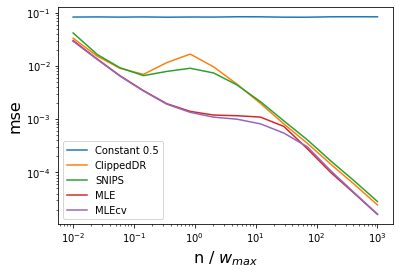

In [7]:
import pickle
del allres
allres = pickle.load(open( "epsilongreedy_estimatewithcv_twoactions_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in reversed(allres):
    FlassPlot.pic([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
FlassPlot.axeslabel('n / $w_{max}$', 'mse')

In [4]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)
  
def getenv():
    import environments.DoubleDouble
    ddm = environments.DoubleDouble.DoubleDouble(numactions=5, seed=5, wsupport=[0, 2, 1000], expwsq=100)
    return (ddm, 1000)

allres = []
for (name, method) in [ 
        ('MLEcv', lambda data, **kwargs: MLE.MLE.estimatewithcv(datagen=lambda: data, **kwargs)[0]),
        ('MLE', lambda data, cvmin, cvmax, **kwargs: MLE.MLE.estimate(datagen=lambda:[(c,w,r) for c, w, r, _ in data], **kwargs)[0]),
        ('SNIPS', lambda data, **kwargs: SNIPS.estimate([(c,w,r) for c, w, r, _ in data], **kwargs)),
        ('ClippedDR', lambda data, **kwargs: ClippedDR.estimate([(c,w,r) for c, w, r, _ in data], **kwargs)),
        ('Constant 0.5', lambda **kwargs: 0.5),
    ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, maxexp=6, numpts=14, ndataperpt=10000):
        res.append(zzz)
        print('{}'.format(zzz), flush=True)
    wmax = getenv()[1]
    allres.append((name, [(x[0] / wmax, x[1]) for x in res]))
    del wmax
import pickle
pickle.dump( allres, open( "epsilongreedy_estimatewithcv_fiveactions_allres.p", "wb" ) )

****** MLEcv ******
(10, {'bias': 0.0040490980435407995, 'mse': 0.028721825490241548, 'ess': 4.542422486759703})
(25, {'bias': 0.0006129460720432862, 'mse': 0.013125790378025366, 'ess': 11.29411273334713})
(59, {'bias': 0.0001816298378389705, 'mse': 0.006407560404671589, 'ess': 26.435087651057525})
(143, {'bias': 0.00051930479979736, 'mse': 0.0033284340578184617, 'ess': 63.7598773178086})
(346, {'bias': 0.00042227547586969115, 'mse': 0.0018706808969225204, 'ess': 150.1521126563842})
(838, {'bias': 6.190206582312145e-05, 'mse': 0.0012897227567211815, 'ess': 347.4286455455199})
(2031, {'bias': 0.0001758373731968281, 'mse': 0.0010340649046823218, 'ess': 750.8385003994929})
(4924, {'bias': 0.0003258577194423138, 'mse': 0.0008859209054201745, 'ess': 1380.066723428562})
(11938, {'bias': 3.245246171587915e-06, 'mse': 0.0007460274930908132, 'ess': 1694.44242507294})
(28943, {'bias': 0.00011027999505743508, 'mse': 0.0005009026155022209, 'ess': 1055.6569996722023})
(70171, {'bias': 0.00017485158

KeyboardInterrupt: 

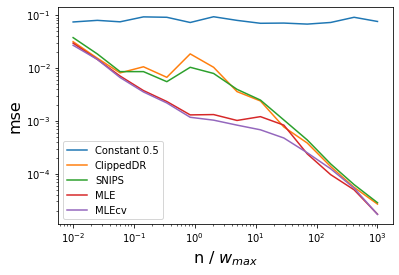

In [6]:
import pickle
del allres
allres = pickle.load(open( "epsilongreedy_estimatewithcv_fiveactions_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in allres:
    FlassPlot.pic([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
FlassPlot.axeslabel('n / $w_{max}$', 'mse')